In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf 
from tensorflow.python.keras._impl.keras.layers.recurrent import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [2]:
dataset = pd.read_csv('./cdn_memory_used.csv', usecols=[0,1,2], index_col=[0], parse_dates=[0])


In [3]:
dataset['2019-01-25 16:01:17']

,host,value
time,,
2019-01-25 16:01:17,fj3-cmcdn0.fjnd.cmcdn.net,5.31417


In [4]:
dataset = dataset.drop(dataset[dataset['host']=='fj3-cmcdn0.fjnd.cmcdn.net'].index, axis=0)
dataset = dataset.drop(dataset[dataset['host']=='gxdd2-cmcdn1.gxnn.cmcdn.net'].index, axis=0)


In [5]:
datasets = []
datasets.append(dataset[dataset['host']=='jswx01-cmcdn0.jswx.cmcdn.net'])
datasets.append(dataset[dataset['host']=='jswx04-cmcdn0.jswx.cmcdn.net'])
datasets.append(dataset[dataset['host']=='sc3-cmcdn3.scyd.cmcdn.net'])
datasets.append(dataset[dataset['host']=='zjwz-cmcdn8.wzyd.cmcdn.net'])
datasets.append(dataset[dataset['host']=='zjwz-cmcdn9.wzyd.cmcdn.net'])

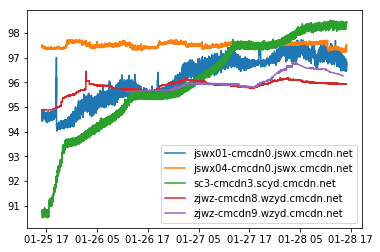

In [6]:
title = ['jswx01-cmcdn0.jswx.cmcdn.net', 'jswx04-cmcdn0.jswx.cmcdn.net', 'sc3-cmcdn3.scyd.cmcdn.net',
        'zjwz-cmcdn8.wzyd.cmcdn.net', 'zjwz-cmcdn9.wzyd.cmcdn.net']
for i in range(len(datasets)):
    plt.plot(datasets[i].value, label=title[i])
    plt.legend()
plt.show()

In [7]:
training_set = datasets[0].iloc[:, 1:2].values
training_set

array([[94.69783302],
       [94.42522675],
       [94.46262695],
       ...,
       [96.71681668],
       [96.844235  ],
       [96.71085205]])

In [8]:
scaler = MinMaxScaler(feature_range=(0,1))
training_set_scaled = scaler.fit_transform(training_set)

In [9]:
# steps = 180
# X_train = []
# Y_train = []
# for i in range(steps, len(training_set_scaled)):
#     X_train.append(training_set_scaled[i-steps])
#     Y_train.append(training_set_scaled[i, 0])
# X_train, Y_train = np.array(X_train), np.array(Y_train)

In [10]:
def create_train_dataset(dataset, steps):
    X_train, Y_train = [], []
    for i in range(steps, len(dataset)):
        X_train.append(training_set_scaled[i-steps])
        Y_train.append(training_set_scaled[i, 0])
    return np.array(X_train), np.array(Y_train)

In [11]:
split_rate = 0.7
k = int(len(training_set_scaled)*split_rate)
def create_test_dataset(dataset, steps):
    X_test, Y_test = [], []
    for i in range(steps, len(dataset)):
        X_test.append(training_set_scaled[i-steps+k])
        Y_test.append(training_set_scaled[i+k, 0])
    return np.array(X_test), np.array(Y_test)


In [12]:
training_set_scaled

array([[0.17993649],
       [0.10768089],
       [0.11759399],
       ...,
       [0.7150778 ],
       [0.74885064],
       [0.71349684]])

In [13]:
train_size = int(len(training_set) * split_rate)
test_size = len(training_set) - train_size
train, test = training_set[0:train_size], training_set[train_size:len(training_set)]


In [14]:
train.shape, test.shape, training_set.shape

((18139, 1), (7775, 1), (25914, 1))

In [15]:
steps = 180
X_train, Y_train = create_train_dataset(train, steps)
X_test, Y_test = create_test_dataset(test, steps)

In [16]:
Y_train.shape,X_train.shape, X_test.shape

((17959,), (17959, 1), (7595, 1))

In [17]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [18]:
X_train.shape

(17959, 1, 1)

In [19]:
regressor = tf.keras.models.Sequential()
regressor.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1],1)))
regressor.add(tf.keras.layers.Dropout(0.2))

regressor.add(LSTM(units=50, return_sequences=True))
regressor.add(tf.keras.layers.Dropout(0.2))

regressor.add(LSTM(units=50, return_sequences=True))
regressor.add(tf.keras.layers.Dropout(0.2))

regressor.add(LSTM(units=50))
regressor.add(tf.keras.layers.Dropout(0.2))

regressor.add(tf.keras.layers.Dense(units=1))

regressor.compile(loss='mean_squared_error', optimizer='Adam')

regressor.fit(X_train, Y_train, epochs=1, batch_size = 20)


Epoch 1/1
17959/17959 [==============================] - 7s 376us/step - loss: 0.0156


In [20]:
trainPredict = regressor.predict(X_train)
testPredict = regressor.predict(X_test)
trainPredict.shape, testPredict.shape

((17959, 1), (7595, 1))

In [21]:
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([Y_train])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([Y_test])
trainY,testY

(array([[94.79820741, 94.70826204, 94.67134373, ..., 96.78097895,
         96.79936384, 96.78685569]]),
 array([[96.81849432, 96.79456607, 96.79743322, ..., 96.71681668,
         96.844235  , 96.71085205]]))

In [22]:
trainPredict, trainY, testPredict, testY

(array([[94.68091],
        [94.41556],
        [94.45163],
        ...,
        [96.76498],
        [96.78742],
        [96.76828]], dtype=float32),
 array([[94.79820741, 94.70826204, 94.67134373, ..., 96.78097895,
         96.79936384, 96.78685569]]),
 array([[96.753334],
        [96.776924],
        [96.76812 ],
        ...,
        [96.67824 ],
        [96.66111 ],
        [96.7908  ]], dtype=float32),
 array([[96.81849432, 96.79456607, 96.79743322, ..., 96.71681668,
         96.844235  , 96.71085205]]))

In [23]:
import math
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))

testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))


Train Score: 0.19 RMSE
Test Score: 0.23 RMSE


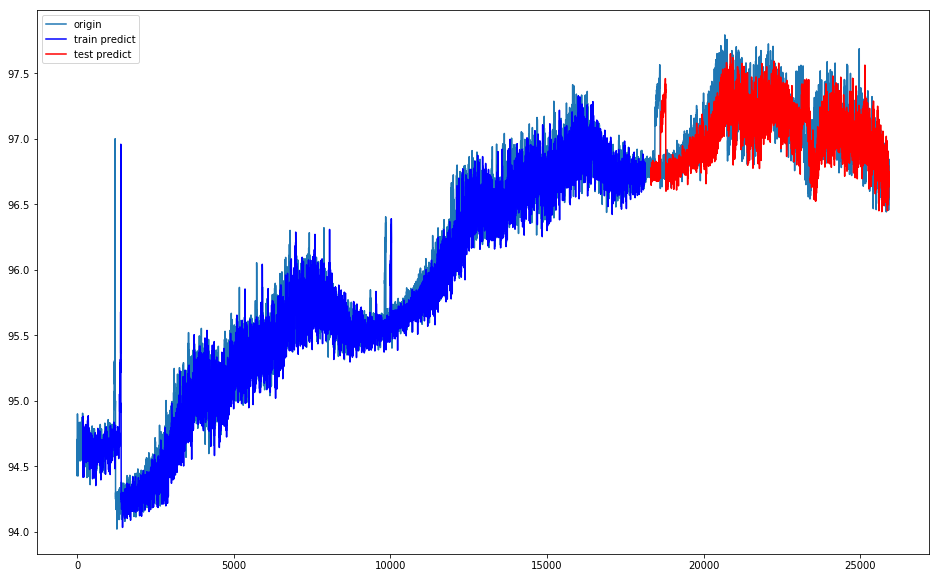

In [24]:
trainPredictPlot = np.empty_like(training_set)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[steps:len(trainPredict)+steps, :] = trainPredict

testPredictPlot = np.empty_like(training_set)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(steps*2):len(training_set),:] = testPredict

plt.figure(figsize=(16,10))
plt.plot(training_set, label = 'origin')
plt.plot(trainPredictPlot, label = 'train predict', color='b')
plt.plot(testPredictPlot, label = 'test predict', color='r')

plt.legend()
plt.show()


In [25]:
datasets[0]['label'] = 0


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [26]:
train_sample = datasets[0].iloc[::6]


In [27]:
train_sample = train_sample.reset_index(drop=True)


In [28]:
train_sample['win_30min_mean'] = train_sample.value.rolling(window=30).mean()
train_sample['win_30min_std'] = train_sample.value.rolling(window=30).std()
train_sample.win_30min_mean.fillna(train_sample.value, inplace=True)
train_sample.win_30min_std.fillna(0, inplace=True)
train_sample['win_30min_value'] = train_sample['win_30min_mean'] + train_sample['win_30min_std']
train_sample.loc[(train_sample['win_30min_value']>85.0) & 
                 (train_sample['win_30min_value']<train_sample['value']), 
                 'label'] = 1

0    3507
1     812
Name: label, dtype: int64

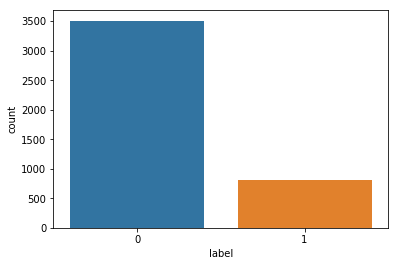

In [29]:
import seaborn as sns
sns.countplot(x="label", data=train_sample)
train_sample.loc[:,'label'].value_counts()
